In [1]:
from os import path, walk
from matplotlib import pyplot as plt
from matplotlib import patches
import random as rd
from tqdm import tqdm
import cv2 as cv
import numpy as np

# custom lib
from alprLib.PlateBoundingBox import PlateBoundingBox

In [2]:
DATASET_PATH = "./archive"
ANNOTATIONS_PATH = path.join(DATASET_PATH, "annotations")
IMAGES_PATH = path.join(DATASET_PATH, "images_resized")

In [5]:
raw_imgs = []
annotations = []
image_filenames = list(walk(IMAGES_PATH))
for image_filename in tqdm(image_filenames[0][2]):
    image_path = path.join(image_filenames[0][0], image_filename)
    img = cv.imread(image_path)
    raw_imgs.append(img)

    annotation = image_filename.split('.')[0] + '.xml'
    annotation_path = path.join(ANNOTATIONS_PATH, annotation)
    annotations.append(PlateBoundingBox.load_from_xml(annotation_path))

100%|██████████| 433/433 [00:03<00:00, 120.93it/s]


image 256
image shape: (320, 512, 3)


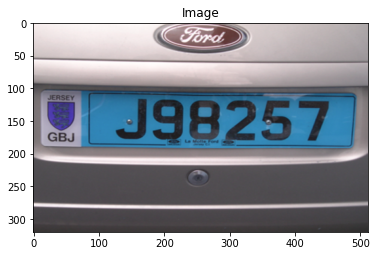

In [17]:
# random index
random_index = rd.randint(0, len(raw_imgs) - 1)
print(f"image {random_index}")

image = raw_imgs[random_index]
plt.figure()
plt.title("Image")
plt.imshow(image)

print(f"image shape: {image.shape}")


In [18]:

def getOutputsNames(net):
    # Get the names of all the layers in the network
    layersNames = net.getLayerNames()
    # Get the names of the output layers, i.e. the layers with unconnected outputs
    return [layersNames[i - 1] for i in net.getUnconnectedOutLayers()]


In [19]:
image_shape = (320, 512)

# Give the configuration and weight files for the model and load the network using them.
modelConfiguration = "yolo_weights/yolov4-tiny.cfg";
modelWeights = "yolo_weights/yolov4-tiny_best.weights";

net = cv.dnn.readNetFromDarknet(modelConfiguration, modelWeights)
net.setPreferableBackend(cv.dnn.DNN_BACKEND_OPENCV)
net.setPreferableTarget(cv.dnn.DNN_TARGET_CPU)
net.enableWinograd(False)

# Create a 4D blob from a frame.
blob = cv.dnn.blobFromImage(image, 1/255, image_shape, [0,0,0], 1, crop=False)

print(f"blob shape : {blob.shape}")

# Sets the input to the network
net.setInput(blob)
# Runs the forward pass to get output of the output layers
outlayersNames = getOutputsNames(net)
print(f"output layers names : {outlayersNames}")
# print(net.getLayerInputs(net.getLayerId(outlayersNames[0])))
outs = net.forward(outlayersNames)

print(outs[0].shape)
print(outs[1].shape)

# print(outs[0])
# print(outs[1])

bbox = [ 
  int(outs[0][0][0]*image_shape[0]),
  int(outs[0][0][1]*image_shape[1]),
  int(outs[0][0][2]*image_shape[0]),
  int(outs[0][0][3]*image_shape[1])
]
print(bbox)


blob shape : (1, 3, 512, 320)
output layers names : ['yolo_30', 'yolo_37']
(480, 6)
(1920, 6)
[13, 20, 90, 35]


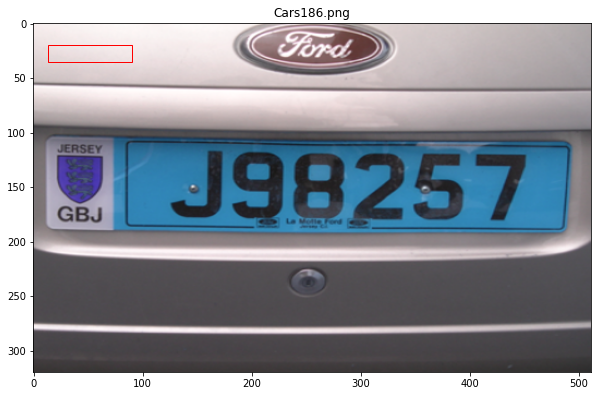

In [20]:

bbox = [
  bbox[0], bbox[1], abs(bbox[0]-bbox[2]), abs(bbox[1]-bbox[3])
]

fig, ax = plt.subplots(figsize=(10,8))
ax.set_title(image_filename)
ax.imshow(image)
rect = patches.Rectangle(
  (bbox[0], bbox[1]), bbox[2], bbox[3], linewidth=1, edgecolor='r', facecolor='none')
ax.add_patch(rect)
